In [15]:
import os

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# from sklearn.metrics import precision_recall_curve, auc

# import missingno as msno
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

# load custom functions
# os.chdir('C:/Users/kyleg/Entity-Matching-in-Online-Retail')
# #  os.chdir('H:/kgilde/Entity-Matching-in-Online-Retail')
# exec(open("utility_functions.py").read())

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# source: https://stackoverflow.com/a/28073228/4463701

pd.set_option('display.max_columns', 50)

In [107]:
def calculate_percent_nulls(df):
    """
    Counts the NaNs by column
    :param df: a Pandas dataframe
    :return: a series of null percentages
    """
    percentages = df.isnull().sum() / len(df) * 100
    percentages_sorted = percentages.sort_values(ascending=False)

    return(percentages_sorted)


In [223]:
raw_df = pd.read_csv('https://raw.githubusercontent.com/curran/data/gh-pages/airbnb/airbnb_session_data.txt',
                    sep='|')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7756 entries, 0 to 7755
Data columns (total 21 columns):
id_visitor                   7756 non-null object
id_session                   7756 non-null object
dim_session_number           7756 non-null int64
dim_user_agent               7537 non-null object
dim_device_app_combo         7756 non-null object
ds                           7756 non-null object
ts_min                       7756 non-null object
ts_max                       7756 non-null object
did_search                   7756 non-null int64
sent_message                 7756 non-null int64
sent_booking_request         7756 non-null int64
next_id_session              7126 non-null object
next_dim_session_number      7126 non-null float64
next_dim_user_agent          6927 non-null object
next_dim_device_app_combo    7126 non-null object
next_ds                      7126 non-null object
next_ts_min                  7126 non-null object
next_ts_max                  7126 non-null obj

# Relationships between the First and Next Sessions

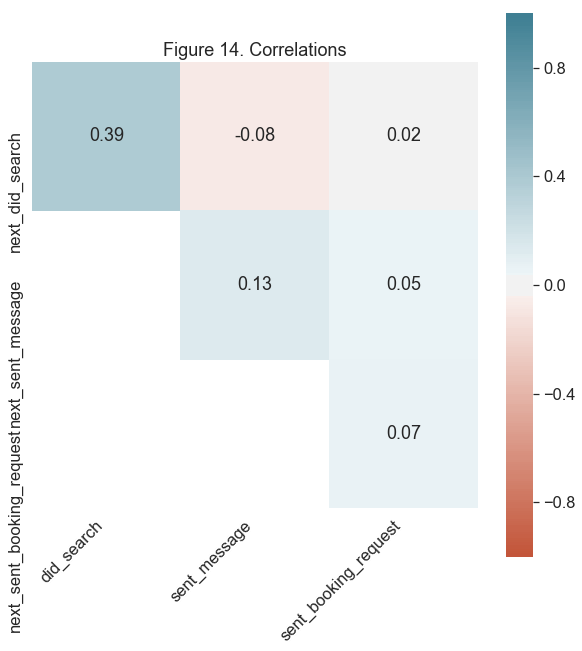

In [221]:
# get columns
flag_columns = pd.Series(['did_search', 'sent_message', 'sent_booking_request'])
next_flag_columns = "next_" + flag_columns
all_flag_columns = flag_columns.append(next_flag_columns)

# create correlations
corr_df = raw_df[all_flag_columns].corr().loc[next_flag_columns][flag_columns]
mask = np.ones(corr_df.shape, dtype='bool')
mask[np.triu_indices(len(corr_df))] = False

# plot correlations
fig, ax = plt.subplots(figsize=(10, 10))
sns.set(font_scale=1.5)
sns.heatmap(
    corr_df, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True, 
    fmt='.2f', 
    mask=mask
).set_title('Figure 14. Correlations')

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.patch.set_visible(False)


# Create Sessions Dataset

- Removed the "next" sessions where a session did not occur.
- Dropped the `dim_user_agent` column since the device and app information was already extracted.

In [296]:
# create DF to hold the "next" session features, remove the rows where a session didn't occur (is_session is null) 
next_columns = raw_df.columns.str.contains('^next_')
next_columns[0] = True
next_df = raw_df.loc[raw_df.next_id_session.notnull(), next_columns].assign(is_next_session = 1)

# create DF to hold the "first" session features
next_columns[0] = False
non_next_df = raw_df.loc[:, ~next_columns].assign(is_next_session = 0)

next_df.set_axis(non_next_df.columns, axis=1, inplace=True)

# combine the sessions into 1 df, drop dim_user_agent
all_sessions_df = pd.concat([non_next_df, next_df], axis=0, ignore_index=True)\
    .drop('dim_user_agent', axis=1)

# all_sessions_df = all_sessions_df.drop('dim_user_agent', axis=1)


print(all_sessions_df.info())
print(calculate_percent_nulls(all_sessions_df))
all_sessions_df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14882 entries, 0 to 14881
Data columns (total 11 columns):
id_visitor              14882 non-null object
id_session              14882 non-null object
dim_session_number      14882 non-null float64
dim_device_app_combo    14882 non-null object
ds                      14882 non-null object
ts_min                  14882 non-null object
ts_max                  14882 non-null object
did_search              14882 non-null float64
sent_message            14882 non-null float64
sent_booking_request    14882 non-null float64
is_next_session         14882 non-null int64
dtypes: float64(4), int64(1), object(6)
memory usage: 1.2+ MB
None
is_next_session         0.0
sent_booking_request    0.0
sent_message            0.0
did_search              0.0
ts_max                  0.0
ts_min                  0.0
ds                      0.0
dim_device_app_combo    0.0
dim_session_number      0.0
id_session              0.0
id_visitor              0.0
dtype: 

id_visitor                630
id_session              13151
dim_session_number        702
dim_user_agent            785
dim_device_app_combo       17
ds                        349
ts_min                   7481
ts_max                   7536
did_search                  2
sent_message                2
sent_booking_request        2
is_next_session             2
dtype: int64

# Feature Engineering

In [440]:
# cast objects to datetime dtype
features_df = \
    all_sessions_df.assign(
    
        ts_min = pd.to_datetime(all_sessions_df.ts_min),
        ts_max = pd.to_datetime(all_sessions_df.ts_max),
        ds = pd.to_datetime(all_sessions_df.ds)
    
    )

split_dim_device_app_combo = features_df.dim_device_app_combo.str.split(' - ', expand=True)

features_df = \
    features_df.assign(

        session_minutes = (features_df.ts_max - features_df.ts_min).astype('timedelta64[m]'),
        day_number = (features_df.ds - features_df.ds.min()).astype('timedelta64[D]'),
        day_of_month = features_df.ts_min.dt.day.astype('category'),
        day_of_week = features_df.ts_min.dt.day_name().astype('category'),
        hour_of_day = features_df.ts_min.dt.hour.astype('category'),
        month = features_df.ts_min.dt.month.astype('category'),
        year = features_df.ts_min.dt.year.astype('category'),
        device = split_dim_device_app_combo.loc[:, 0],
        app = split_dim_device_app_combo.loc[:, 1]
#         sent_booking_request = features_df.sent_booking_request#.astype('category')
#         did_search = did_search.astype('category')
#         sent_message = sent_message.astype('category')
#         is_next_session = is_next_session.astype('category')
        
    ).drop(['ds', 'ts_min', 'ts_max', 'id_session'], axis=1)



features_df.info()
print(features_df.head())
print(calculate_percent_nulls(features_df))
features_df.nunique()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14882 entries, 0 to 14881
Data columns (total 16 columns):
id_visitor              14882 non-null object
dim_session_number      14882 non-null float64
dim_device_app_combo    14882 non-null object
did_search              14882 non-null float64
sent_message            14882 non-null float64
sent_booking_request    14882 non-null float64
is_next_session         14882 non-null int64
session_minutes         14882 non-null float64
day_number              14882 non-null float64
day_of_month            14882 non-null category
day_of_week             14882 non-null category
hour_of_day             14882 non-null category
month                   14882 non-null category
year                    14882 non-null category
device                  14882 non-null object
app                     14882 non-null object
dtypes: category(5), float64(6), int64(1), object(4)
memory usage: 1.3+ MB
                             id_visitor  dim_session_number  \
0 

id_visitor              630
dim_session_number      702
dim_device_app_combo     17
did_search                2
sent_message              2
sent_booking_request      2
is_next_session           2
session_minutes         169
day_number              349
day_of_month             31
day_of_week               7
hour_of_day              24
month                    12
year                      2
device                    7
app                       9
dtype: int64

# Exploratory Data Analysis

In [391]:
top_20_values
# top_20_values.info()

,variable,value,value_count
9,day_of_month,15,519
8,day_of_month,11,532
7,day_of_month,23,540
6,day_of_month,22,546
5,day_of_month,28,548
4,day_of_month,5,549
3,day_of_month,9,560
2,day_of_month,2,588
1,day_of_month,8,599
0,day_of_month,6,603


In [399]:
top_20_values =\
    features_df\
        .melt()\
        .groupby(['variable', 'value'])['value']\
        .agg('count')\
        .to_frame()\
        .rename(index=str, columns={'value': 'value_count'})\
        .reset_index()\
        .groupby(['variable'])\
        .apply(lambda x: x.nlargest(10, 'value_count'))\
        .reset_index(drop=True)\
        .sort_values(['variable', 'value_count'])

top_20_values['value'] = top_20_values.value.str.slice(stop=25)

Text(0.5, 0.98, 'Top Values')

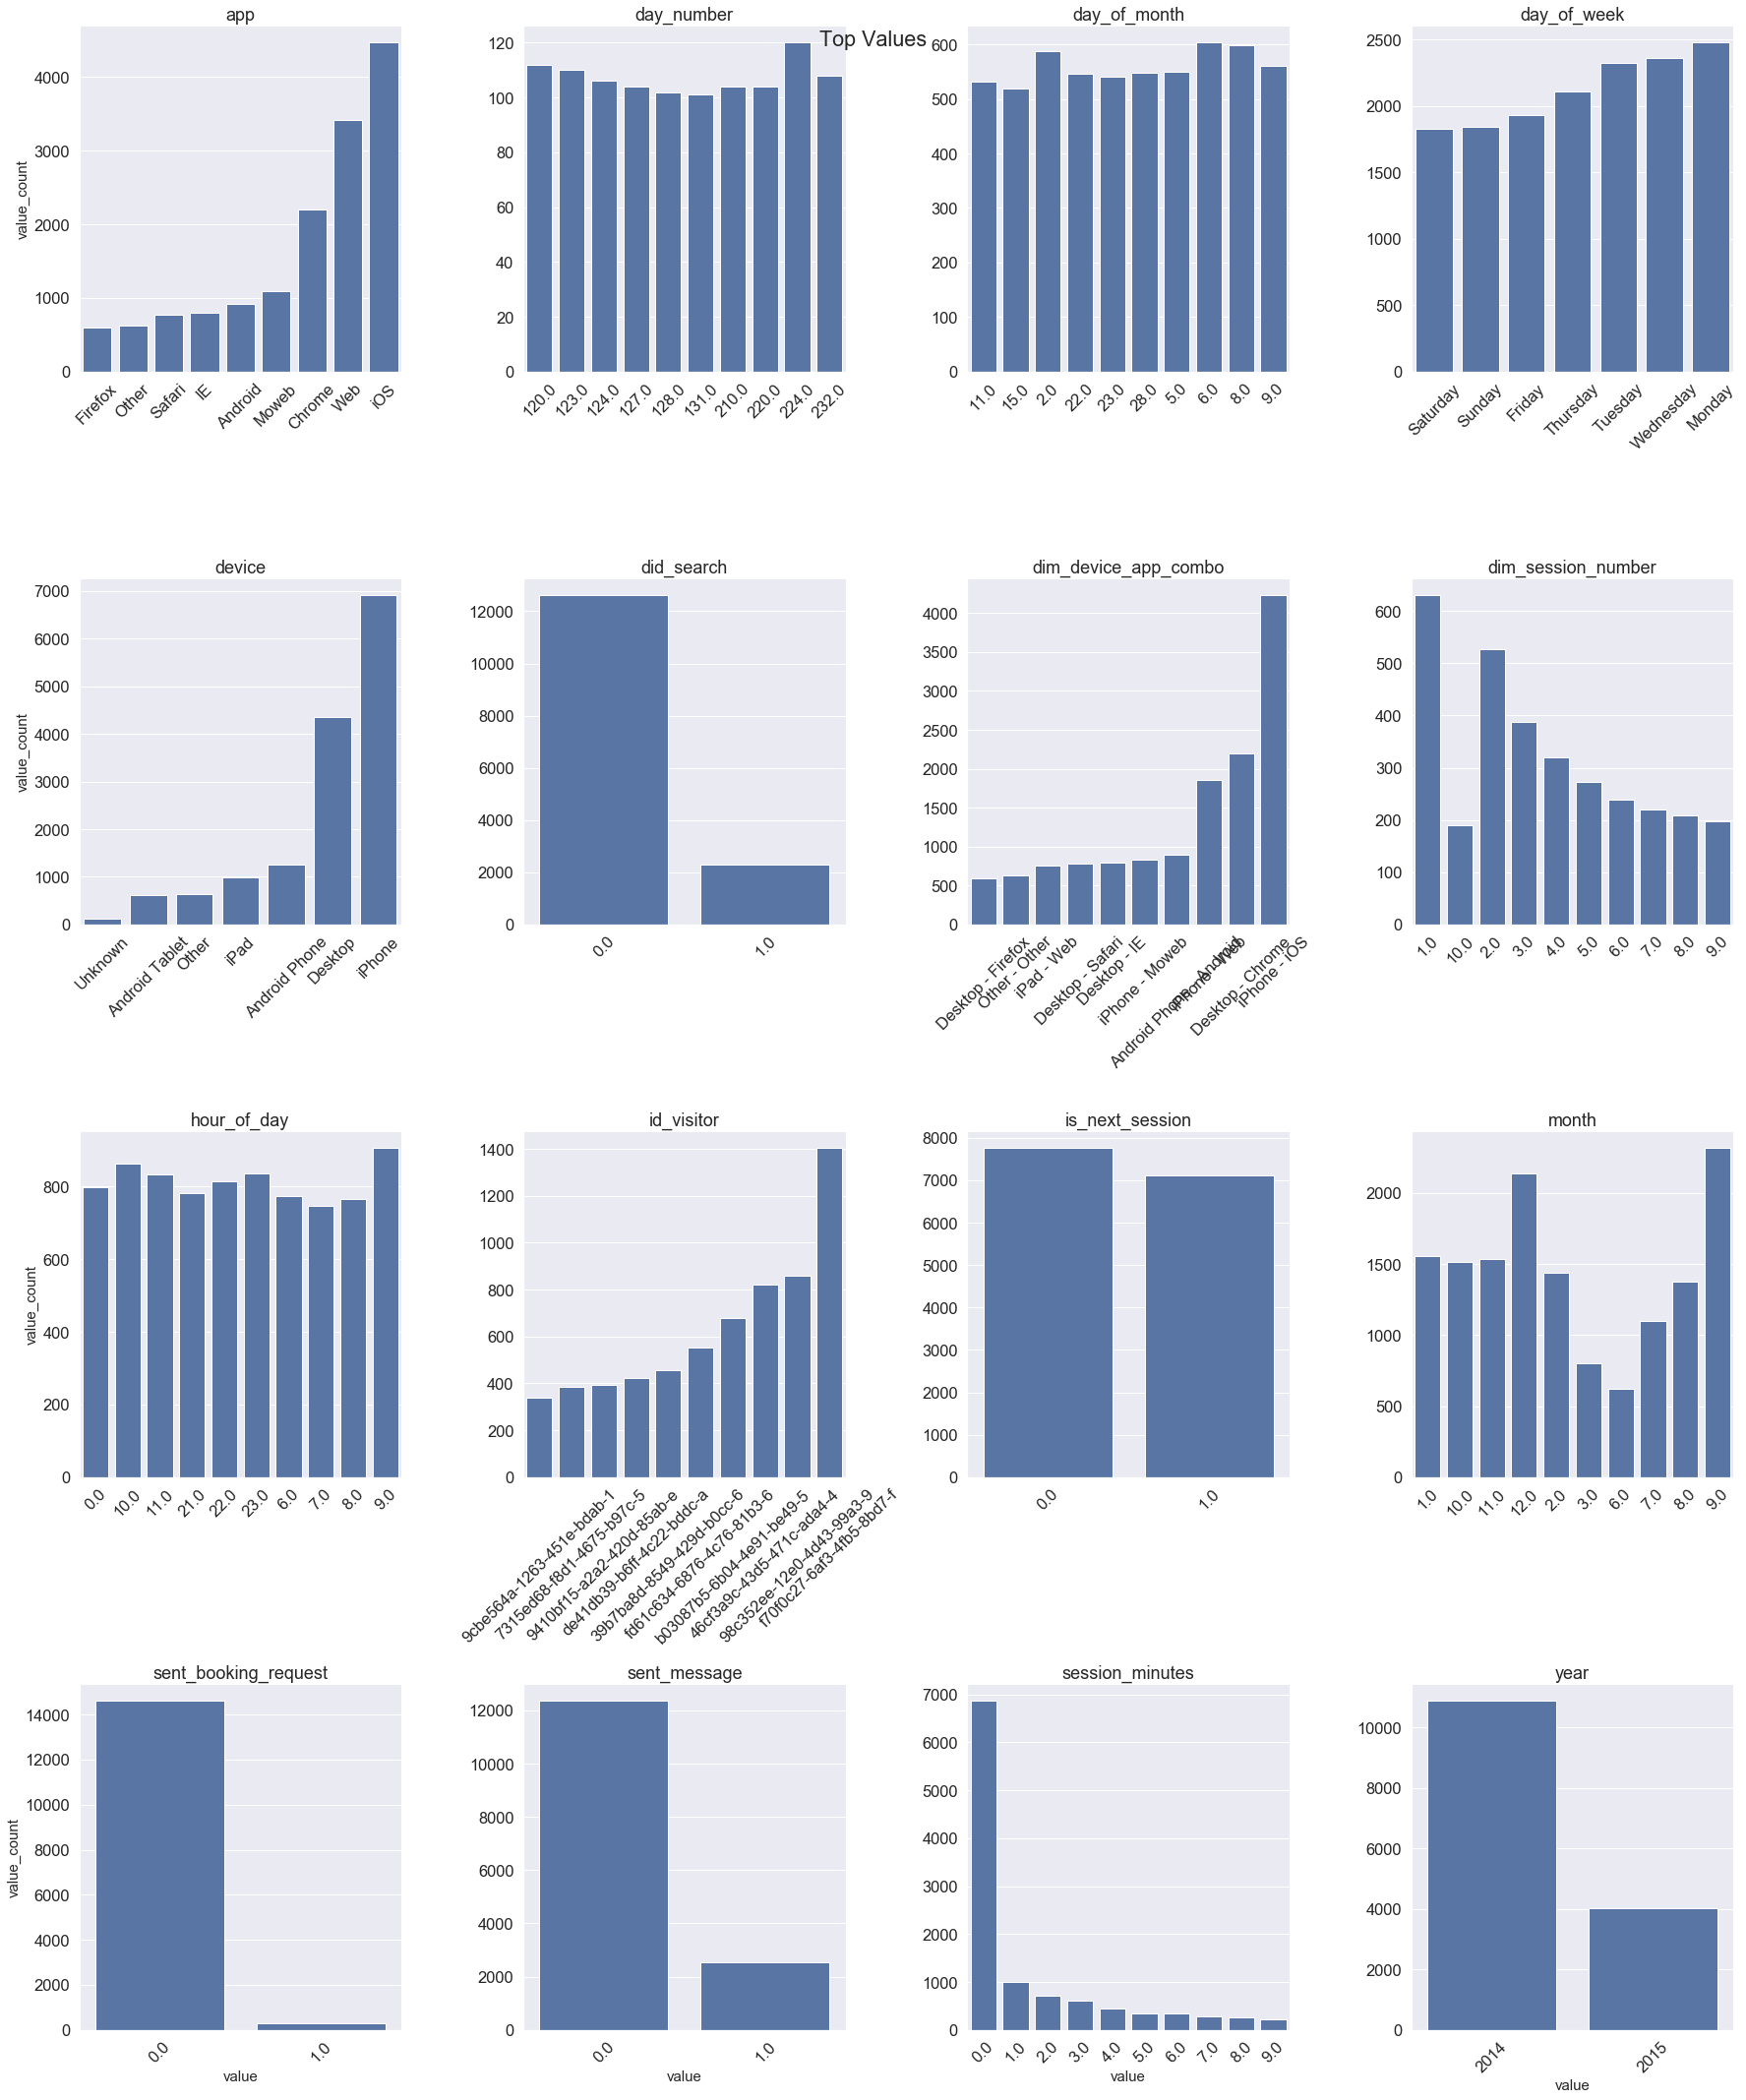

In [427]:
#[['day_of_week', 'day_of_month']]\

# st = fig.suptitle("Counts for the Top 10 Common Values")

plt.rcParams["axes.labelsize"] = 15
g = sns.FacetGrid(top_20_values, col="variable", col_wrap=4, sharey=False, sharex=False)
g.fig.set_figwidth(25)
g.fig.set_figheight(30)
sns.set(font_scale=1.5)

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.map(sns.barplot, 'value', 'value_count')
g.set_titles('{col_name}')
# g.fig.suptitle("Top Values")

# g.map(sns.barplot, 'value_count', 'value')
# sns.catplot(data=top_20_values, x='value_count', y='value', hue='variable', kind='bar', sharey=False, sharex=False)

In [436]:
numeric_feature_corr = features_df.loc[:, features_df.apply(is_numeric_dtype)].corr()  
mask = np.zeros_like(numeric_feature_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

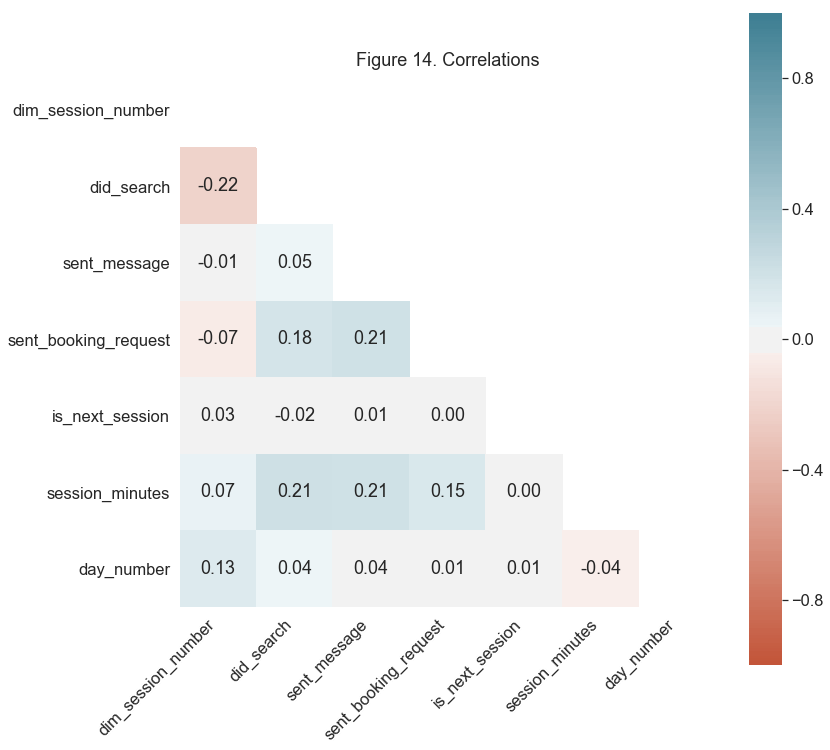

In [438]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.set(font_scale=1.5)
sns.heatmap(
    numeric_feature_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True, 
    fmt='.2f', 
    mask=mask
).set_title('Correlations')

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.patch.set_visible(False)

# source: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

In [ ]:
pd.melt(features_df[['dim_session_number','session_minutes','day_number', 'sent_booking_request']],
        id_vars='sent_booking_request')

In [444]:
sns.set(font_scale=1.5)

g = sns.catplot(col="variable", 
                y='value',
                x="label",
                data=attribute_comp_features_9_feat_label_melted,
                palette="husl", 
                col_wrap=3,
                kind="box",
                height=3)

t = g.fig.suptitle('Figure 15. Side-by-Side Boxplots', y=1.08)

NameError: name 'attribute_comp_features_9_feat_label_melted' is not defined

Duration

Seasonality

Device, App, Searches and Messagin